<a href="https://colab.research.google.com/github/mrospond/kik/blob/main/W02_KiK_zrodla_kanaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Potrzebne biblioteki...

# Obliczenia matematyczne, dla nas głównie logarytm
import math

# Generowanie liczb losowych
import random

# Praca z wektorami i macierzami
import numpy as np

# Rysowanie standardowych wykresów
import matplotlib.pyplot as plt
# Obróbka statystyczna przy rysowaniu wykresów i formatowaniu ich wyglądu
import seaborn as sns
sns.set()

# Obliczenia probabilistyczne
## Dowolny rozkład dyskretny
from scipy.stats import rv_discrete
## Entropia Shannona i dywergencja Kullbacka-Leiblera
from scipy.stats import entropy
## Estymacja jądrowa (ang. kernel density estimation) rozkładu prawdopodobieństwa z próbek
from scipy.stats import gaussian_kde

# Obsługa plików
## Pobieranie
import requests
## Rozpakowywanie
import zipfile

# Obróbka języka naturalnego: generowanie n-gramów i rozkładów warunkowych
import string
## Zliczanie statystyk językowych
import nltk
from nltk import ConditionalFreqDist

# Badanie języka z użyciem entropii

In [ ]:
#@title Użyjemy korpusu języka angielskiego (przykładowy tekst)
#@markdown Alice = Alicja w Krainie Czarów

url = 'http://corpus.canterbury.ac.nz/resources/cantrbry.zip'
r = requests.get(url, allow_redirects=True)

open('cantrbry.zip', 'wb').write(r.content)
with zipfile.ZipFile('cantrbry.zip', 'r') as zip_ref:
    zip_ref.extractall('cantrbry')

with open('cantrbry/alice29.txt', encoding='utf8') as f:
    text = f.read()
f.close()

text = text.upper()
print(text[:1000])





                ALICE'S ADVENTURES IN WONDERLAND

                          LEWIS CARROLL

               THE MILLENNIUM FULCRUM EDITION 2.9




                            CHAPTER I

                      DOWN THE RABBIT-HOLE


  ALICE WAS BEGINNING TO GET VERY TIRED OF SITTING BY HER SISTER
ON THE BANK, AND OF HAVING NOTHING TO DO:  ONCE OR TWICE SHE HAD
PEEPED INTO THE BOOK HER SISTER WAS READING, BUT IT HAD NO
PICTURES OR CONVERSATIONS IN IT, `AND WHAT IS THE USE OF A BOOK,'
THOUGHT ALICE `WITHOUT PICTURES OR CONVERSATION?'

  SO SHE WAS CONSIDERING IN HER OWN MIND (AS WELL AS SHE COULD,
FOR THE HOT DAY MADE HER FEEL VERY SLEEPY AND STUPID), WHETHER
THE PLEASURE OF MAKING A DAISY-CHAIN WOULD BE WORTH THE TROUBLE
OF GETTING UP AND PICKING THE DAISIES, WHEN SUDDENLY A WHITE
RABBIT WITH PINK EYES RAN CLOSE BY HER.

  THERE WAS NOTHING SO VERY REMARKABLE IN THAT; NOR DID ALICE
THINK IT SO VERY MUCH OUT OF THE WAY TO HEAR THE RABBIT SAY TO
ITSELF, `OH DEAR!  OH DEAR!  I SHALL BE LAT

In [ ]:
#@markdown Policzymy na tej książce statystkę liter w języku angielskim

# Ograniczamy się do liter, bo w tekście występują też jakieś kropki, spacje itd.
Vocabulary = list(string.ascii_uppercase) 
print(Vocabulary)

# Słownik częstotliwości występowania liter w języku angielskim
freq = dict(zip(Vocabulary,[0 for _ in range(len(Vocabulary))]))
how_many = 0

for char in text:
  if char in freq:
    how_many += 1
    freq[char] += 1

for elem in freq:
  freq[elem] /= how_many

print(f"W korpusie Alicja mamy {how_many} liter.")

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
W korpusie Alicja mamy 107667 liter.


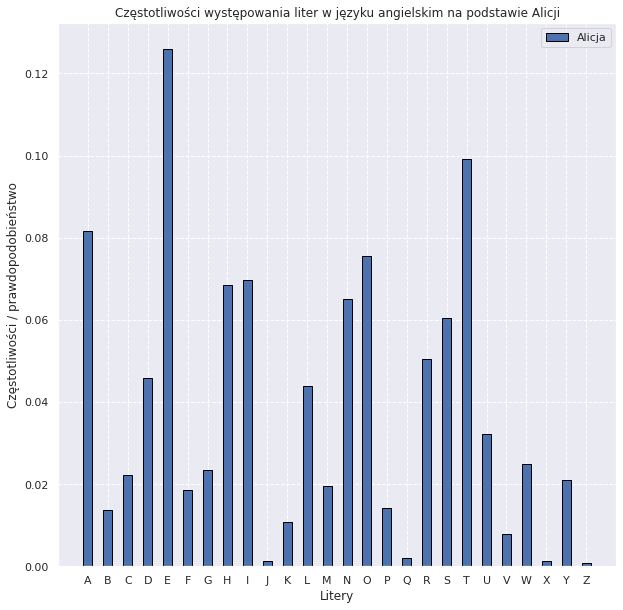

Entropia na podstawie Alicji: 4.160930615023794 bitów/literę, 
przy potencjalnie maksymalnej entropii dla takiego alfabetu: 4.700439718141092 bitów/literę.


In [ ]:
#@markdown Sprawdźmy, jak wygląda statystyka

ile = len(Vocabulary)
r = np.arange(ile)
szerokosc = 0.45

plt.figure(figsize=(10,10))
plt.bar(Vocabulary, freq.values(), 
        width = szerokosc, edgecolor = 'black',
        label='Alicja')

plt.title('Częstotliwości występowania liter w języku angielskim na podstawie Alicji')
plt.xlabel('Litery')
plt.xticks(r, Vocabulary)
plt.ylabel('Częstotliwości / prawdopodobieństwo')
plt.grid(linestyle='--')
plt.legend()
plt.show()

prawdopodobienstwa = list(freq.values())
print(f"Entropia na podstawie Alicji: {entropy(prawdopodobienstwa,base=2)} bitów/literę, \nprzy potencjalnie maksymalnej entropii dla takiego alfabetu: {math.log2(len(prawdopodobienstwa))} bitów/literę.")

Widać, że nawet pół bita to może być dosyć dużo!

Entropia jest niższa niż dla równomiernego rozkładu częstotliwości liter:
*   Co to znaczy?
*   Czy można jeszcze dokładniej oszacować entropię języka angielskiego?

Swoją drogą, **jak takie dane można wykorzystać w kryptoanalizie**?

In [ ]:
#@title { run: "auto" }
#@markdown Na ile wytworzony rozkład coś nam mówi o języku Alicji?

ile = 30 #@param {type: "slider", min:10, max:100, step:20}

liczby = list(range(len(Vocabulary)))
custm = rv_discrete(values=(liczby, prawdopodobienstwa))

probka_liczby = custm.rvs(size=ile)
alfabet = dict(zip(liczby,Vocabulary))
probka = [alfabet[key] for key in probka_liczby]

print(''.join(probka))

IEUIEAISUPEUERDTERNLWCCTHGFATL


Co może bardziej przypominać język? Normalnie znamy przecież kontekst (na tym też opiera się NLP z użyciem UM)...

In [ ]:
#@title Wytworzymy częstotliwości względne dla liter
#@markdown * Prawdopodobieństwa warunkowe typu $\Pr\{a|b\}$: jakie jest prawdopodobieństwo, że bo literze $b$ wystąpi litera $a$?
#@markdown * Nie będziemy tego już robić na piechotę, wykorzystamy narzędzia do obróbki języka
#@markdown * Tokenizacja = wydzielenie podstawowych obiektów językowych (tu akurat: liter), ważne w NLP w przypadku UM
#@markdown * Okno przesuwne zbiera nam tzw. $n$-gramy (tutaj $n=2$ generuje bigramy, bo sprawdzamy jakie jest prawdopodobieństwo, że jedna litera wystąpi po drugiej)

# Bierzemy tylko litery (tokenizacja na poziomie znaków)
filtered_text = [token for token in text if token in Vocabulary]

# Obliczamy częstotliwości względne na podstawie bigramów: zestawów po dwie kolejne litery (np. `ba`)
cfd = ConditionalFreqDist(nltk.bigrams(filtered_text))

print("Przykładowe bigramy:")
for n, bigram in enumerate(nltk.bigrams(filtered_text)):
  if n >=0 and n<=15:
    print(bigram)

Przykładowe bigramy:
('A', 'L')
('L', 'I')
('I', 'C')
('C', 'E')
('E', 'S')
('S', 'A')
('A', 'D')
('D', 'V')
('V', 'E')
('E', 'N')
('N', 'T')
('T', 'U')
('U', 'R')
('R', 'E')
('E', 'S')
('S', 'I')


In [ ]:
#@markdown * To jest dużo większa statystyka niż dla pojedynczych liter!
#@markdown * Dla pojedynczych liter był wykres (liniowy), tu jest cała tablica (można byłoby zwizualizować na wykresie 3D)

print(cfd.tabulate())

     A    B    C    D    E    F    G    H    I    J    K    L    M    N    O    P    Q    R    S    T    U    V    W    X    Y    Z 
A    9  251  208  477    0   93  203   48  719   15  130 1047  232 1621    6  152    3  729  964 1221   78  201  111    4  260    5 
B   81   66    0    1  524    0    0    1  111    7    0  105    1    0  203    0    0   59   27    9  204    0    0    0   75    0 
C  317    1   16    0  704    0    0  449   30    0  177   66    0    0  341    0    0  110    1   74  103    0    0    0    8    0 
D  542  163   57  120  472   91   86  181  451   15    8  123   60  184  595   47   14  137  340  841  100   48  155    0  100    0 
E 1252  240  439 1204  568  265  306  347  383   47  122  608  508 1052  367  285   98 1991 1179 1004   41  230  601  104  314   14 
F  195   23   40    7  163  133   12   64  250    1    3   53   25   15  342   12    2   94   52  320  108    6   34    0   46    0 
G  385   37   13   26  297   28   23  371  175    4    1   77   27   

W powyższej tabeli: warunki w wierszach - czyli np. E po A występuje bardzo często, ale A po E w ogóle...

In [ ]:
#@title { run: "auto" }
#@markdown Przerabiamy na rozkład prawdopodobieństwa

cpd = nltk.ConditionalProbDist(cfd, nltk.MLEProbDist)

#@markdown Wypiszemy dla dwóch liter
jedna = "A" #@param {type:"string"}
druga = "E" #@param {type:"string"}

litery = [jedna, druga]

for condition in cfd.conditions():
  if condition in litery:
    print(f"\nPo {condition}:")
    for event in cfd[condition]:
        probability = cpd[condition].prob(event)
        print(f"\tnastępuje {event}: {probability:.4f}")


Po A:
	następuje N: 0.1845
	następuje T: 0.1390
	następuje L: 0.1192
	następuje S: 0.1097
	następuje R: 0.0830
	następuje I: 0.0818
	następuje D: 0.0543
	następuje Y: 0.0296
	następuje B: 0.0286
	następuje M: 0.0264
	następuje C: 0.0237
	następuje G: 0.0231
	następuje V: 0.0229
	następuje P: 0.0173
	następuje K: 0.0148
	następuje W: 0.0126
	następuje F: 0.0106
	następuje U: 0.0089
	następuje H: 0.0055
	następuje J: 0.0017
	następuje A: 0.0010
	następuje O: 0.0007
	następuje Z: 0.0006
	następuje X: 0.0005
	następuje Q: 0.0003

Po E:
	następuje R: 0.1467
	następuje A: 0.0923
	następuje D: 0.0887
	następuje S: 0.0869
	następuje N: 0.0775
	następuje T: 0.0740
	następuje L: 0.0448
	następuje W: 0.0443
	następuje E: 0.0419
	następuje M: 0.0374
	następuje C: 0.0324
	następuje I: 0.0282
	następuje O: 0.0270
	następuje H: 0.0256
	następuje Y: 0.0231
	następuje G: 0.0226
	następuje P: 0.0210
	następuje F: 0.0195
	następuje B: 0.0177
	następuje V: 0.0170
	następuje K: 0.0090
	następuje X: 0.0077

In [ ]:
#@title { run: "auto" }
#@markdown Próbkujemy dla takiego rozkładu warunkowego

# Długość
ile = 100 #@param {type:"integer"}

# Start
start_bigram = ("A","L")

# Wygenerowany tekst
generated_text = [start_bigram[0], start_bigram[1]]

for i in range(ile):
    # poprzednia litera
    last = generated_text[-1]
    # częstotliwości warunkowane ostatnią literą
    bigram_cpd = cpd[last]
    # losujemy z takiego prawdopodobieństwa następną literę
    next = random.choices(list(bigram_cpd.samples()), weights=list(bigram_cpd.freqdist().values()))[0]
    # dodajemy nową literę
    generated_text.append(next)

generated_text_str = ''.join(generated_text)
print(generated_text_str)

ALLYOUSHEDLINECHEDWOCANGOUHTANWASTASOOUMEWINIFSCESLYIRESENFINASAYWHIGTHIEPEQUCRLCOUREYORISHITTSTSMOATHASAMBEHGOWINELLESAITASANOENTHAINTHEENEROSOVEADBEDBBYPLILEJULEYHTTTMBLEOUERSHEXEEDANOWEYOUTHEHESOOOLSHOULEHALIKICERUMUCELENHAITANGHEDSTTYJUISYTHEDOMYITHAISHANISGINGOLSINDTHITHOPLLIGEFSAPEDBOMTHERARLINDINLATHEATTIERMAMUTOFLOALOWIKNDATLONDHICOREORECIEWOINGANICKANOULLKFOOUDSARHEQUCLYGAMAYDWHTECARTAINOUCLESTOUASHEEETTIDTHERFITRTHECEMIRUSWHEYARALEREPPEHYOUNDNETHEQUKETHILLAIFPINSHALINETEVEPAITWADHLINGSITEWENDPIPILOULTYTHEAPICEALITAYITHANSOUTHALTHEETHENCHEDTHASHEMACOUTHTHACOUCREQUTILYSHENDOUTHEDOPEFITOGWOMULITAYMALITHEAICANCONGSTHICRNORHETTTDOUREWHSWECKEYOKIGTSITLINOFONGSOMOMININDTFOINDOULLLAISTHASSALOINDINDNGHAISQUNGIKITHERALTQUNCHEREBOOWOWHEDSANLLERATHELIKISATOSTHTHERLSHEGGODITIETHIMSTHOFUNOURSHANHEWHRMWYORPLITHEWERGTAVEBUPONDOURERECEAYORTHYMAWARUNSINDSTOUSWECOFTHSMULOSCIERESONINATOMBEMETTHEWISOTYBECEYINDOUNKINTJEOOUPOUASANDDENSIOERUNINTUROGTTHTHASARYATHERIDIDHELTHARIRESOUSFYGOTLLLLLAICKESAT

In [ ]:
#@title { run: "auto" }
#@markdown * A teraz jeszcze dokładniej: statystyki typu $\Pr\{a|b,c\}$
#@markdown * Okno przesuwne zbiera nam trigramy (tutaj $n=3$, bo sprawdzamy jakie jest prawdopodobieństwo, że jedna litera wystąpi po dwóch literach)

# Długość
ile = 100 #@param {type:"integer"}

trigrams = list(nltk.trigrams(filtered_text))

cfd = nltk.ConditionalFreqDist(((w1, w2), w3) for w1, w2, w3 in trigrams)
cpd = nltk.ConditionalProbDist(cfd, nltk.MLEProbDist)

start_trigram = ("A", "L", "I")
generated_text = [start_trigram[0], start_trigram[1], start_trigram[2]]

for i in range(ile):
    last_two_words = (generated_text[-2], generated_text[-1])
    trigram_cpd = cpd[last_two_words]
    next_word = trigram_cpd.generate()
    generated_text.append(next_word)

generated_text_str = ''.join(generated_text)
print(generated_text_str)

ALITGOFHJUDLYCLEABOUWOLDDERSHURTINKYLOWNOSHEFONTANDHANDTHEWHEMENOTMALOVERSHERTHERPROUTWHADIFANDSAIDORGE


In [ ]:
#@title Lepiej jak zachowamy spacje i inne znaki 
#@markdown Najpierw zbierzemy statystyki, czyli oszacowania:
#@markdown * Na podstawie unigramów: $\Pr\{.\}$
#@markdown * Na podstawie unigramów: $\Pr\{a|.\}$
#@markdown * Na podstawie unigramów: $\Pr\{a|b.\}$

unigrams = list("".join(text))
bigrams = list(nltk.bigrams(text))
trigrams = list(nltk.trigrams(text))

freq_dist = nltk.FreqDist(unigrams)
total_letters = len(unigrams)
probabilities = {letter: freq / total_letters for letter, freq in freq_dist.items()}

# print the top 10 most probable letters
print("Dziesięć najczęstszych znaków:")
for letter, probability in sorted(probabilities.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{letter}: {probability:.3f}")

cfd2 = nltk.ConditionalFreqDist(bigrams)
cpd2 = nltk.ConditionalProbDist(cfd2, nltk.MLEProbDist)

cfd3 = nltk.ConditionalFreqDist(((w1, w2), w3) for w1, w2, w3 in trigrams)
cpd3 = nltk.ConditionalProbDist(cfd3, nltk.MLEProbDist)

start_digram = ("A", "L")
start_trigram = ("A", "L", "I")

generated_text2 = [start_trigram[0], start_trigram[1]]
generated_text3 = [start_trigram[0], start_trigram[1], start_trigram[2]]

for i in range(ile):
    last_word = (generated_text3[-1])
    trigram_cpd2 = cpd2[last_word]
    next_word2 = trigram_cpd2.generate()
    generated_text2.append(next_word2)

    last_two_words = (generated_text3[-2], generated_text3[-1])
    trigram_cpd3 = cpd3[last_two_words]
    next_word3 = trigram_cpd3.generate()
    generated_text3.append(next_word3)

Dziesięć najczęstszych znaków:
 : 0.195
E: 0.091
T: 0.072
A: 0.059
O: 0.055
I: 0.051
H: 0.050
N: 0.047
S: 0.044
R: 0.037


W Alicji spacja jest najczęstsza, a nie litera `E`...

In [ ]:
#@title { run: "auto" }
#@markdown Obejrzymy sobie, na ile sekwencje losowe przypominają język, gdy będziemy próbkować z coraz precyzyjniejszych rozkładów

# Długość
ile = 48 #@param {type:"integer"}

generated_text1 = random.choices(list(probabilities.keys()), weights=list(probabilities.values()), k=ile)
print("="*50)
print("Bezwarunkowo")
print("="*50)
generated_text_str1 = ''.join(generated_text1)
print(generated_text_str1)
print("="*50)
print("="*50)
print()

print("="*50)
print("Warunek: jedna litera")
print("="*50)
generated_text_str2 = ''.join(generated_text2)
print(generated_text_str2)
print("="*50)
print("="*50)
print()

print("="*50)
print("Warunek: dwie litery")
print("="*50)
generated_text_str3 = ''.join(generated_text3)
print(generated_text_str3)

Bezwarunkowo
TOISER`LNLDE TRL LLT WOOLFEYOF  S  KN H ASTHLUTO

Warunek: jedna litera
ALEI, L HAETIFOGTA AEM ;LOOG  INL TI:`USHTYL ,FRL TAIUHC -GI RN T TTIM:RHOTT TU  VE EN    NY'EBTAUPY  

Warunek: dwie litery
ALIED AFTER LOW SLE
DODY CON THE GULD BUTILL YOULETCHOW THAT WAS SAID TOGS HE OF IT
MOURT ALITY WOURE;



Oczywiście w NLP tokenizujemy na podstawie słów, a nie liter. Proszę się zastanowić, jak ogromne statystyki musielibyśmy przechowywać, gdybyśmy przetwarzali bezpośrednio prawdopodobieństwa warunkowe!

## Jak się te rozkłady prawdopodobieństwa mają do entropii?

Im więcej wiemy, tym mniej jesteśmy zaskoczeni! Czyli: entropia jest zrelatywizowana do naszej wiedzy nt. źródła wiadomości.

In [ ]:
#@markdown Policzymy trzy entropie: bezwarunkową i dwie warunkowe

print(f'Entropia BEZWARUNKOWA dla pojedynczych znaków: {entropy(list(probabilities.values()),base=2)} bit/znak.')

prawd_pairs = {}
entropy2 = 0
for condition1 in cfd2.conditions():
    p_sum = 0
    for event in cfd2[condition1]:
        p = cpd2[condition1].prob(event)
        prawd_pairs[(condition1,event)] = probabilities[condition1] * p
        p_sum += prawd_pairs[(condition1,event)] * math.log2(p)
    entropy2 -= p_sum
print(f'Entropia WARUNKOWA na podstawie bigramów (warunek: pojedyncza litera): {entropy2} bit/znak.')

Entropia BEZWARUNKOWA dla pojedynczych znaków: 4.339002576245449 bit/znak.
Entropia WARUNKOWA na podstawie bigramów (warunek: pojedyncza litera): 3.45133919483068 bit/znak.


*   Już pojedynczy warunek wprowadza ogromny spadek entropii (prawie o 1 bit)! Dla rozszerzania warunków o kolejne litery ten spadek wartości nie jest już tak radykalny.
*   Dla trigramów jeszcze mniejsza wartość entropii - można policzyć samodzielnie (byleby poprawnie). Przewidziano [bonusy do aktywności](https://upel.agh.edu.pl/mod/assign/view.php?id=112861) za ćwiczenia :)
*   Entropia dla pojedynczych znaków jest większa niż dla pojedynczych liter (obliczona wcześniej, przy okazji wykresu częstotliwości). Dlaczego?

Przy okazji liczenia entropii zebraliśmy sobie też oszacowanie statystyczne prawdopodobieństw łącznych $\Pr\{a,b\}$. Teraz to wykorzystamy.

In [ ]:
#@markdown Co myśmy tu sobie zebrali...

ile_tego = 0
sumuje_sie = 0

print("Przykładowe prawdopodobieństwa dla bigramów: ")
for condition1 in cfd2.conditions():
    for event in cfd2[condition1]:
      pr = prawd_pairs[(condition1,event)]
      sumuje_sie += pr
      ile_tego += 1
      if ile_tego>138 and ile_tego<148:
        print(f'Pr({condition1}{event}) = {pr}')

print()
print(f"Wartości sumują się do {sumuje_sie}. Co to znaczy?")
print(f"\nJest ich w sumie: {ile_tego}. Dlaczego tyle wartości?")

Przykładowe prawdopodobieństwa dla bigramów: 
Pr(IM) = 0.00149514079242462
Pr(IR) = 0.001441261844949859
Pr(IG) = 0.0014075875027781332
Pr(IE) = 0.0012863598709599209
Pr(IO) = 0.0011651322391417083
Pr(IF) = 0.0010775789494952216
Pr(I') = 0.0009092072386365933
Pr(IK) = 0.0006532822381314781
Pr(IV) = 0.00040409210606070817

Wartości sumują się do 0.9999932651315666. Co to znaczy?

Jest ich w sumie: 805. Dlaczego tyle wartości?


In [ ]:
#@title Entropia łączna (też bezwarunkowa) dla bigramów
#@markdown Policzyliśmy już $H(Y)$, $H(X|Y)$, zobaczymy jeszcze entropię łączną (też bezwarunkową) $H(X,Y)$

entr_joint = entropy(list(prawd_pairs.values()),base=2)

print(f'Entropia ŁĄCZNA dla bigramów: {entr_joint} bit/bigram. Wartość maksymalna mogłaby wynieść: {math.log2(ile_tego)}.')
print(f'To znaczy, że gdy patrzymy na sekwencję - entropia na znak: {entr_joint/2} bit/(znak w sekwencji).')

Entropia ŁĄCZNA dla bigramów: 7.79026881669023 bit/bigram. Wartość maksymalna mogłaby wynieść: 9.65284497300198.
To znaczy, że gdy patrzymy na sekwencję - entropia na znak: 3.895134408345115 bit/(znak w sekwencji).


Można zerknąć na wartości i widać **regułę łańcuchową** dla entropii:

$$H(X,Y) = H(Y) + H(X|Y) = H(X) + H(Y|X)$$

Tutaj $H(X) = H(Y)$, bo $X$ oraz $Y$ oznacza to samo, czyli rozkład pojedynczych znaków. Oczywiście w wielu przypadkach (np. kanałów transmisyjnych) to są różne zmienne losowe.

# Dywergencja Kullbacka-Leiblera

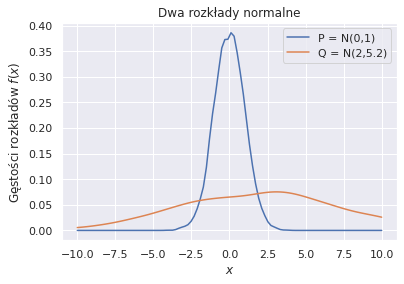

D(P/Q) = 1.761367556648817


In [ ]:
#@title { run: "auto" }

loc = 2  #@param {type: "slider", min:-5, max:5, step:0.5}
scale = 5.2 #@param {type: "slider", min:0.1, max:10.1, step:0.1}
liczba_punktow = 5000 #@param {type:"integer"}

sample1 = np.random.normal(0, 1, liczba_punktow)
sample2 = np.random.normal(loc, scale, liczba_punktow)

pdf1 = gaussian_kde(sample1)
pdf2 = gaussian_kde(sample2)

x = np.linspace(-10, 10, 100)
density1 = pdf1(x)
density2 = pdf2(x)

eps = 1e-9
density1 += eps
density2 += eps

plt.plot(x, density1, label = 'P = N(0,1)')
plt.plot(x, density2, label = f'Q = N({loc},{scale})')
plt.title('Dwa rozkłady normalne')
plt.xlabel(f'$x$')
plt.ylabel(f'Gęstości rozkładów $f(x)$')
plt.legend()
plt.show()

kl_divergence = entropy(pk=density1, qk=density2, base=2)
print(f"D(P/Q) = {kl_divergence}")

Tutaj liczymy rozbieżność na podstawie estymaty z próbek. Akurat dla rozkładów normalnych można ładnie policzyć $D_{\text{KL}}(P||Q) = f(\mu_1,\mu_2,\sigma_1,\sigma_2)$.